# `func_adl` Hello World

This will show you the simplests scripts to get data back via `func_adl` from an flat ROOT tuple file and from an ATLAS `xAOD` file.

These tutorials assume you have a properly configured `.servicex` file with ServiceX access information.

## Flat ROOT File

To make these examples easy to cut-paste, they are run in a single cell. The text after wards will explain them line-by-line.

In [1]:
from func_adl_servicex import ServiceXSourceUpROOT

dataset_uproot = "user.kchoi:user.kchoi.ttHML_80fb_ttbar"
ds = ServiceXSourceUpROOT(dataset_uproot, "nominal")
data = ds.Select("lambda e: {'lep_pt_1': e.lep_Pt_1/1000.0}") \
    .AsAwkwardArray() \
    .value()

In [2]:
data['lep_pt_1']

<ChunkedArray [29.69721 59.942165 18.633768 ... 22.894817 28.860708 179.20753] at 0x01da8cab98c8>

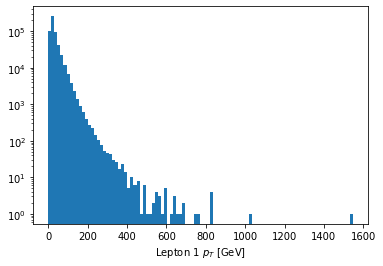

In [3]:
import matplotlib.pyplot as plt
plt.hist(data['lep_pt_1'].flatten(), bins=100)
plt.yscale('log')
_ = plt.xlabel('Lepton 1 $p_T$ [GeV]')

The first cell retreives the data from ServiceX as an Awkward array. The second plots it - and should be mostly familiar.

### Lets go line-by-line

1. The import `ServiceXSourceUpROOT` is a `func_adl` data source. In this case, it indicates a ServiceX backend that can work with flat ROOT files.
1. Blank line
1. This is the dataset that we will be reading from. This must be a `rucio` dataset identifier (DID). In this case we are working with an ATLAS backend, and this is a flat root file in a user scope.
1. Here the data source is created.

  - Since this is a flat root file and it may contian many `TTree`'s, we have to give it a tree name. In this case we give it `nominal`.
  - The best way to think of the object `ds` is as a sequence of `Event` objects. Each `Event` object contains all the data for a single event.

1. This is the first line of the selection.
  - We start with the data set source, which is a sequence of events.
  - The `Select` is applied to each `Event` in the sequence.
  - The `e` in the lambda expression represents the data in that event. In this case, all the leaves in the ROOT TTree.
  - The python dictionary specifies the columns we want.
  - 'lep_pt_1' is what we will call the name of the column below.
  - 'e.lep_Pt_1/1000.0' is what we will fill the 'lep_pt_1' with as it is returned from ServiceX. In this case, the `lep_Pt_1` branch, converted from units of MEV to GeV
1. `AsAwkwardArray` tells the system to return the data as an Awkward array.
  - Behind your back parquet files will be returned to a local disk cache
  - These files are then loaded into memory as `Awkward` arrays, the four file contactinated.
  - The order of contactination is maintained accross queries, so it is possible to combine two queries.
1. Up to now, nothing has been done: a list of instructions has been assembled. The `.value()` triggers the system to send the request out to ServiceX and fetch the data back.

The second cell plots. As this is fairly standard python plotting code, there are only a few things to call attention to, and they are both contained in this expression: `data['lep_pt_1'].flatten()`.

- The `'lep_pt_1'` is the same as the name of the column in the dictionary from the first cell, line 5.
- The `.flatten()` is because the data may come back as a jagged array, and matplotlib does not know what to do with that data. In this partiuclar case, that does not happen, so the `flatten` is not needed. We've left it in as this is a common mistake for people starting out.

A final note, if you try re-runnign the first cell you'll note it executes much faster than previously. This is because the data has been cached on your machine and the system recognizes that you've asked for the same data again.

## ATLAS xAOD File

An ATLAS `xAOD` file is a binary format that requires a C++ framework to read. There is a special ServiceX transformer that can read these files.

In [4]:
from func_adl_servicex import ServiceXSourceXAOD

dataset_xaod = "mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00"
ds = ServiceXSourceXAOD(dataset_xaod)
data = ds \
    .Select('lambda e: e.Jets("AntiKt4EMTopoJets")') \
    .Select('lambda jets: jets.Where(lambda j: (j.pt()/1000)>30)') \
    .Select('lambda good_jets: good_jets.Select(lambda j: j.pt()/1000.0)') \
    .AsAwkwardArray(["JetPt"]) \
    .value()

In [5]:
data['JetPt']

<ChunkedArray [[36.319765625 34.3319140625] [35.84151171875] [33.7014375] ... [46.931421875 36.22234375] [60.069671875 54.458859375] [47.65314453125 32.738951171875]] at 0x01dad341e8c8>

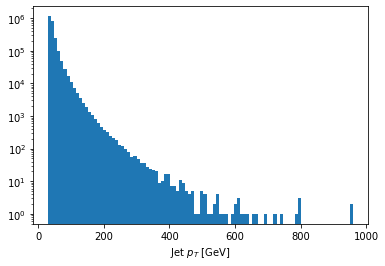

In [6]:
import matplotlib.pyplot as plt
plt.hist(data['JetPt'].flatten(), bins=100)
plt.yscale('log')
_ = plt.xlabel('Jet $p_T$ [GeV]')

## Lets break down the query line-by-line

1. The import `ServiceXSourceXAOD` is a `func_adl` data source. In this case, it indicates a ServiceX backend that can work with an ATLAS `xAOD` file.
1. Blank line
1. This is the dataset that we will be reading from. This must be a `rucio` dataset identifier (DID). In this case it is an old $Z->ee$ Monte Carlo file form a Standard Model derivation.
1. Here the data source is created.
  - The best way to think of the object `ds` is as a sequence of `Event` objects. Each `Event` object contains all the data for a single event.
1. This is the first line of the selection. We start with the data set source, which is a sequence of events.
1. The `Select` is applied to each `Event` in the sequence. This selection takes an `Event` object and returns a list of jets.
  - In ATLAS one has to specify the `xAOD` bank name - which is `'AntiKtEMTopoJets'` in this case.
  - Note that as a result of this `Select` statement we are now dealing with a sequence of arrays of jets. So if the first event has 3 jets, the second 2, and the third 4, then we might have `[(j11, j12, j13), (j21, j22), (j31, j32, j33, j34)]`.
1. We want to include jets that have a $p_T$ larger than 30 GeV only in the results. So do this, we need to apply the `Where` function on each jet's $p_T$.
  - The first Select means we are dealing at the event level - or the list of jets. So if we are working on the first event, then `jets` represents `(j11, j12, j13)`.
  - The `Where` then filters each jet. In this case by converting the `j.pt()` to GeV and then asking for it to be at least 30.
  - If the jet $p_T$'s of the first event are `(45, 22, 55)` GeV, then after the `Select` the first event list of jets will look like `(j11, j13)`.
1. We wnat the jet $p_T$ as our result. Again, we have to operate on each jet, rather than the sequence of jets.
  - The inner `Select` transforms the jets into $p_T$'s.
  - If the first event is as above, then after the event `Select` completes, this will look like `(45, 55)`.
1. `AsAwkwardArray` tells the system to return the data as an Awkward array.
  - Behind your back ROOT files will be returned to a local disk cache
  - These files are then loaded into memory as `Awkward` arrays, the four file contactinated.
  - The order of contactination is maintained accross queries, so it is possible to combine two queries.  
1. Up to now, nothing has been done: a list of instructions has been assembled. The `.value()` triggers the system to send the request out to ServiceX and fetch the data back.

The query here is very similar to the one in the ROOT section. A key difference here is that we are keeping the event strucutre. Rather than a list of leptons, we have a list of events, and inside we have the jets. You can see this in the `data['JetPt']`. This makes the query a level more complex. If you want to flatten the output during generation from ServiceX, that isn't very hard. See the advanced section and the use of the `SelectMany` method.

A final note, if you try re-runnign the first cell you'll note it executes much faster than previously. This is because the data has been cached on your machine and the system recognizes that you've asked for the same data again.